In [1]:
import numpy as np
from utils import Spike,sort_neurons
import pickle
from tqdm import trange
from hdpp import Hierarchical_Dirichlet_Point_Process
from matplotlib import pyplot as plt

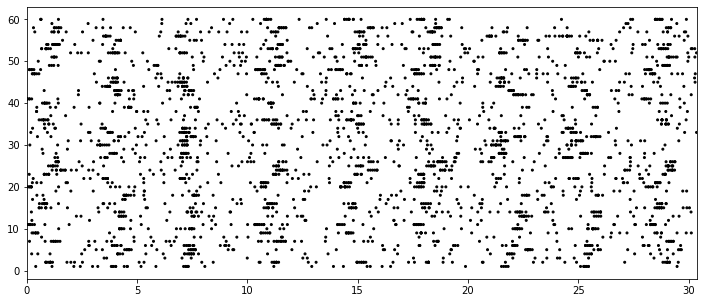

In [2]:
# Load data
spikes = np.load("./data/synthetic.npy", allow_pickle=True)
num_neurons = int(np.max(spikes[:, 0]))
num_spikes = len(spikes)
max_time = np.max(spikes[:, 1])
cmap = np.array(['black'] * num_spikes)
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
ax.scatter(spikes[:,1],spikes[:,0],c=cmap,s=4)
ax.set_xlim([0,max_time])
plt.show()

In [3]:
# Hyperparameter setting
particle_num = 20                       # the number of particles
g_0 = 0.2                               # concentration parameter in Dirichlet NPP
lambda_0 = 0.001                        # concentration parameter in Dirichlet HP
theta0 = np.array([1] * num_neurons)    # prior of Dirichlet distribution
g_noise = [100, 300]                    # background noise rate
beta = [5, 0.1]                         # prior of sequence amplitude
alpha = [10, 5]                         # prior of kernel parameter in Dirichlet HP
normal_inverse_chi_squared_prior = [1.0, 10.0, 0, 0.1]  # k, v, mu, sigma
bandwidth = np.array([0.5])             # bandwidth of kernel in Dirichlet HP
refrence_time = 2                       # refrence time of kernel in Dirichlet HP
threshold = 0.025                       # particle resampling threshold
prune_threshold = 0.5                   # prune threshold
merge_threshold = 0.8                   # merge threshold
drop_threshold = 60                     # drop threshold
window_size = 6                         # look back time duration for efficient implementation

In [4]:
hdpp = Hierarchical_Dirichlet_Point_Process(
    num_neurons=num_neurons,
    particle_num=particle_num,
    g_0=g_0,
    lambda_0=lambda_0,
    theta_0=theta0,
    g_noise = g_noise,
    alpha=alpha,
    beta=beta,
    normal_inverse_chi_squared_prior=normal_inverse_chi_squared_prior,
    bandwidth=bandwidth,
    refrence_time=refrence_time,
    threshold=threshold,
    prune_threshold=prune_threshold,
    merge_threshold=merge_threshold,
    drop_threshold=drop_threshold,
    window_size=window_size,
)

for i in trange(num_spikes):
    spike = Spike(i, int(spikes[i, 0])-1, spikes[i, 1], num_neurons)
    hdpp.particle_filters(spike)
# To perform a final pruning
hdpp.final_drop()

saved_data = {"particles": hdpp.particles, "particle_num": particle_num, "normal_inverse_chi_squared_prior": normal_inverse_chi_squared_prior, "g_noise": g_noise, "g_0": g_0,
              "lambda_0": lambda_0, "theta0": theta0, "beta": beta, "alpha": alpha, "bandwidth": bandwidth, "refrence_time": refrence_time, "prune_threshold": prune_threshold,
              "merge_threshold": merge_threshold, "drop_threshold": drop_threshold, "window_size": window_size}

with open('./particles.pkl', 'wb') as w:
    pickle.dump(saved_data, w)

100%|██████████| 2902/2902 [00:44<00:00, 65.26it/s]


In [9]:
# load model

# filepath = "./pre_trained_model/"
# data_type = "syn_"
filepath = "./"
data_type = ""

with open(filepath + data_type + 'particles.pkl','rb') as f:
    particles = pickle.load(f)['particles']
weights = []
for particle in particles:
    weights.append(particle.weight)
weights = np.array(weights)
index = np.argmax(weights)
particle = particles[index]
# load saved sequence indicators (for memory efficiency, we save sequences indicators of those spikes far away from current time to disk while inference)
for seq_index, sequence in particle.sequences.items():
    if seq_index != 1 and not sequence.spikes:
        path = filepath + data_type + "sequences/sequence_spikes_" + str(seq_index)+".npy"
        sequence.spikes = np.load(path, allow_pickle=True).item()

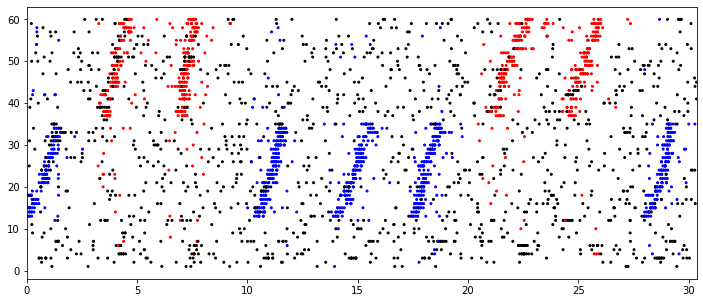

In [10]:
# sort neurons based on offset, type and weight
sorted_spikes = sort_neurons(spikes, particle, 0.2)

cmap = np.array(['black'] * num_spikes)
colors = ['b','r','g','y','m','peru','coral','gold','purple']
count = 0
for target_type_index, seq_type in particle.seq_types.items():
    seq_indexes_this_type = particle.seq_type_to_sequences[target_type_index]
    spike_indexes_this_type = []
    for index in seq_indexes_this_type:
        spikes_seq = particle.sequences[index].spikes
        indices = []
        for spike_neuron_index in spikes_seq.keys():
            spike_index = np.array(spikes_seq[spike_neuron_index])[:,1].astype(np.int32).tolist()
            indices += spike_index
        spike_indexes_this_type += indices
    cmap[spike_indexes_this_type] = colors[count]
    count += 1
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
ax.scatter(sorted_spikes[:,1],sorted_spikes[:,0],c=cmap,s=4)
ax.set_xlim([0,max_time])
plt.show()